In [1]:
#Importing the Neccessary Libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [2]:
data = pd.read_csv("../Data/histopathologic-cancer-detection/train_labels.csv")
train_path = "../Data/histopathologic-cancer-detection/train"
test_path = "../Data/histopathologic-cancer-detection/test"

data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [4]:
#Plotting some Images with and without Cancer tissue for comparision
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_image = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b, g, r = cv2.split(bgr_image)
    rgb_image = cv2.merge([r,g,b])
    return rgb_image

Text(0, 0.5, 'Positive(Tumor) tissue samples')

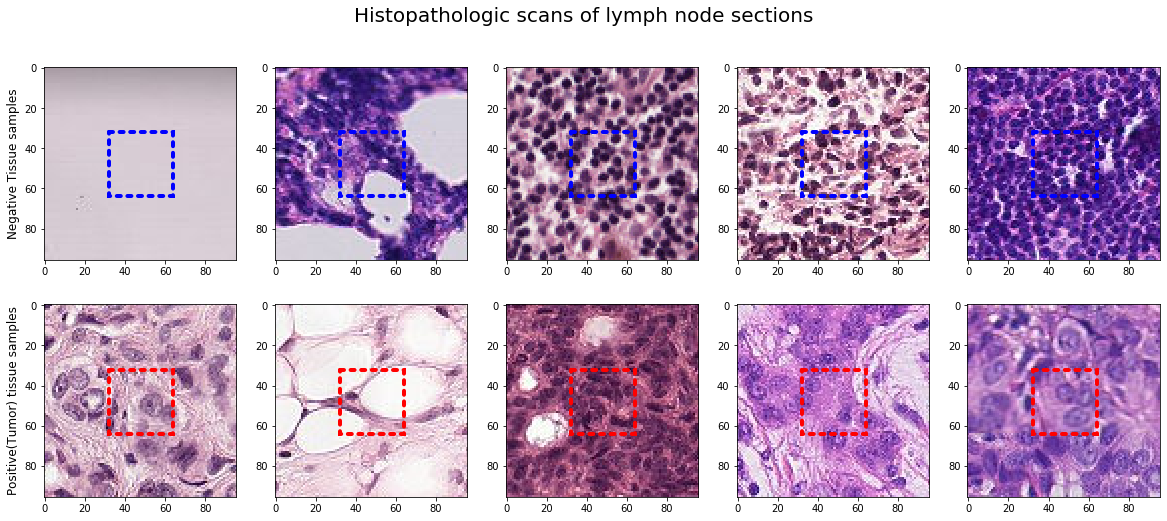

In [5]:
#Shuffling the Data and sampling it randomly
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2, 5, figsize=(20,8))
fig.suptitle("Histopathologic scans of lymph node sections", fontsize=20)

#Negatives - Meaning having no cancer
for i, idx in enumerate(shuffled_data[shuffled_data["label"] == 0]["id"][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative Tissue samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Positive(Tumor) tissue samples', size='large')

In [ ]:
#Visualization
#Importing some more libraries